In [29]:
pip install geopandas folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
#import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import webbrowser
import os
from statsmodels.formula.api import ols
from scipy import stats
from datetime import datetime
from sklearn import preprocessing, linear_model
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#your file path may be different
data = pd.read_csv("/content/drive/MyDrive/Colab/NJ/NJData.csv")
education = pd.read_csv("/content/drive/MyDrive/Colab/NJ/NJEducation.csv")
racial = pd.read_csv("/content/drive/MyDrive/Colab/NJ/NJRacial.csv")
townships = gpd.read_file("/content/drive/MyDrive/Colab/NJ/tl_2021_34_cousub/tl_2021_34_cousub.shp") 
townships['GEOID']=townships['GEOID'].astype(int)
counties = gpd.read_file("/content/drive/MyDrive/Colab/NJ/tl_2010_34_county10/tl_2010_34_county10.shp") 


In [32]:
def merge(shapefile, dataset, column):
  return shapefile.merge(dataset, on=column)

In [33]:
withElectionData = merge(townships,data,"GEOID")
withTwoData = merge(withElectionData,education,"GEOID")
filled = merge(withTwoData,racial,"GEOID")

In [34]:
def electionInteractive(year, min, max):
  return filled.explore(column = year, tooltip = ["NAMELSAD","Pres16","Pres20","Swing"], cmap = "RdBu", vmin = min, vmax = max, style_kwds = {"fillOpacity":1,"weight":1,"color":"Black"})

In [35]:
def demographicInteractive(demographic):
  return filled.explore(column = demographic, tooltip = ["NAMELSAD",demographic], cmap = "Greys", vmin = 0, vmax = 1, style_kwds = {"fillOpacity":1,"weight":1,"color":"Black"})

In [36]:
def predictionInteractive(year, min, max):
  return filled.explore(column = year, tooltip = ["NAMELSAD","Pres20","Predicted","Difference"], cmap = "RdBu", vmin = min, vmax = max, style_kwds = {"fillOpacity":1,"weight":1,"color":"Black"})

In [37]:
def plot(xAxis,yAxis):
  plot = filled.plot.scatter(x = xAxis, y = yAxis, c = 'DarkBlue')
  m, b = np.polyfit(filled[xAxis], filled[yAxis], 1)
  plt.plot(filled[xAxis], m*filled[xAxis]+b)

In [38]:
def getDemo(i,type):
  return filled._get_value(i, type)

In [39]:
def regression(xAxis,yAxis):
  model = ols(xAxis + " ~ " + yAxis, data=filled).fit()
  return model.summary()

In [40]:
X = filled[['White', 'Black', 'Asian', 'Hispanic', 'Education']]
y = filled['Pres20']
regr = linear_model.LinearRegression()
regr.fit(X.values, y)

LinearRegression()

In [41]:
Predicted = []
for i in range(len(filled)):
  Predicted.append(regr.predict([[getDemo(i,"White"),getDemo(i,"Black"),getDemo(i,"Asian"),getDemo(i,"Hispanic"),getDemo(i,"Education")]])[0])
filled['Predicted'] = Predicted
filled['Difference'] = filled['Predicted'] - filled['Pres20']

In [42]:
electionMap = electionInteractive("Pres20",-0.8,0.8)
electionMap

Output hidden; open in https://colab.research.google.com to view.

In [43]:
demographicMap = demographicInteractive("Education")
demographicMap

Output hidden; open in https://colab.research.google.com to view.

In [44]:
predictedMap = predictionInteractive("Difference",-0.8,0.8)
predictedMap

Output hidden; open in https://colab.research.google.com to view.

In [45]:
modelSummary = regression("White","Swing")
modelSummary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  White   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     275.6
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           1.14e-50
Time:                        05:26:29   Log-Likelihood:                 167.44
No. Observations:                 565   AIC:                            -330.9
Df Residuals:                     563   BIC:                            -322.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6019      0.010     62.397      0.000       0.583       0.621
Swing          1.9361      0.117     16.601      0.000       1.707       2.165
==============================================================================
Omnibus:                       46.386   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.693
Skew:                          -0.515   Prob(JB):                     9.07e-20
Kurtosis:                       4.632   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

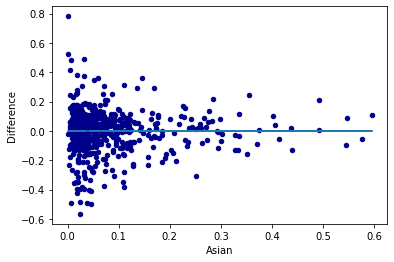

In [46]:
plot("Asian","Difference")